(tut_sw_data)=

# Working with space weather data

```{versionadded} 7.3.0

```

heyoka.py provides the ability to access [space weather](https://en.wikipedia.org/wiki/Space_weather) (SW) data and even use it in the [expression system](<./The expression system.ipynb>). Space weather support enables accurate modeling of atmospheric density variations, capturing effects such as solar activity and geomagnetic storms that influence atmospheric drag on Earth-orbiting spacecraft - improving the precision of orbit predictions, especially in low Earth orbit (LEO).

## Accessing the raw data

The raw SW data is encapsulated in the {py:class}`~heyoka.sw_data` class. Let us explore it a bit.

In [16]:
# Default-construct an sw_data instance.
import heyoka as hy

data = hy.sw_data()

The raw data is available via the {py:attr}`~heyoka.sw_data.table` property, which returns a {ref}`structured NumPy array<numpy:defining-structured-types>` containing a time series of the SW data:

In [17]:
data.table

array([(36112., 21, 269.3, 266.6), (36113., 12, 253.3, 267.4),
       (36114., 19, 266.3, 268.1), ..., (60822.,  6, 146.1, 160.4),
       (60823., 25, 155.8, 160.6), (60824., 35, 150.9, 161. )],
      shape=(24713,), dtype={'names': ['mjd', 'Ap_avg', 'f107', 'f107a_center81'], 'formats': ['<f8', '<u2', '<f8', '<f8'], 'offsets': [0, 8, 16, 24], 'itemsize': 32, 'aligned': True})

The dtype of the array is {py:attr}`~heyoka.sw_data_row`, which includes:

- the UTC MJD (``mjd``),
- the arithmetic average of the 8 [Ap indices](https://en.wikipedia.org/wiki/K-index) for the day,
- the observed 10.7-cm [solar radio flux](https://en.wikipedia.org/wiki/Solar_flux_unit) (F10.7),
- the 81-day arithmetic average of the observed F10.7 centred on the day.

## Updating the SW data

A default-constructed {py:class}`~heyoka.sw_data` instance uses a builtin SW dataset from [celestrak](https://celestrak.org/SpaceData/). This dataset is comprehensive, including both historical data dating back to the 50s and predictions for the near future.

Although the builtin dataset is updated at every new heyoka.py release, it is likely to be outdated, at least for operational uses. For this reason, the {py:class}`~heyoka.sw_data` class provides static factory methods to construct {py:class}`~heyoka.sw_data` instances from up-to-date datasets downloaded from the internet.

As an example, we can use {py:func}`~heyoka.sw_data.fetch_latest_celestrak()` to download the dataset covering the last 5 years before present from celestrak:

In [18]:
updated_data = hy.sw_data.fetch_latest_celestrak()

Please see the documentation of {py:class}`~heyoka.sw_data` for more detailed information.

## Using the SW data in the expression system

The SW data can also be used in the expression system via several functions available in the {ref}`model<api_model>` submodule. These currently include:

- the arithmetic average of the Ap indices {py:func}`~heyoka.model.Ap_avg()`,
- the observed 10.7-cm solar radio flux {py:func}`~heyoka.model.f107()`,
- the 81-day arithmetic average of the observed 10.7-cm solar radio flux {py:func}`~heyoka.model.f107a_center81()`.

The functions are all implemented as [piecewise constant functions](https://en.wikipedia.org/wiki/Piecewise_constant_function) of the input time.

All these functions take in input a time expression meant to represent the number of Julian centuries elapsed since the epoch of J2000 in the [terrestrial time (TT) timescale](https://en.wikipedia.org/wiki/Terrestrial_Time). They also accept as a second argument the {py:class}`~heyoka.sw_data` dataset to be used in the computation.

Here is an example of computation and visualisation of the time evolution of the observed 10.7-cm solar radio flux and its average using heyoka.py's [compiled functions](<./compiled_functions.ipynb>):

In [23]:
import numpy as np

# Define the computation timespan: 22 years following J2000.
tspan = np.linspace(0, 0.22, 10000)

# Introduce a symbolic variable for the representation of time.
tm = hy.make_vars("tm")

# Construct a compiled function for the computation of the 10.7-cm solar radio flux.
cf = hy.cfunc(
    [hy.model.f107(time_expr=tm), hy.model.f107a_center81(time_expr=tm)], [tm]
)

# Compute the values of f107 and its average over tspan.
f107, f107a = cf(inputs=[tspan])

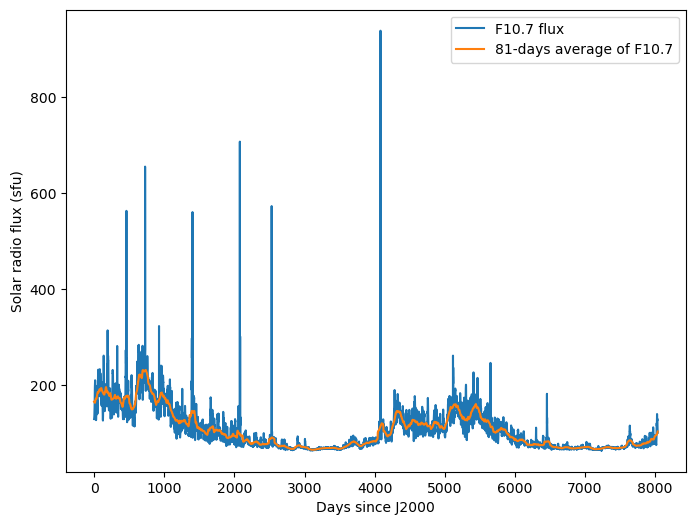

In [24]:
%matplotlib inline
from matplotlib.pylab import plt

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot()

# Convert the timespan to days for visualisation.
cy_to_days = 36525

ax.plot(tspan * cy_to_days, f107, label="F10.7 flux")
ax.plot(tspan * cy_to_days, f107a, label="81-days average of F10.7")
ax.set_xlabel("Days since J2000")
ax.set_ylabel("Solar radio flux (sfu)")
ax.legend();